##### Authors
- Daniel Jove Díaz
- Pablo Fuentes Chemes

# CUSTOM CONVOLUTIONAL NEURAL NETWORKS

In this practice, we will develop a custom convolutional neural network from scratch to tackle the classification problem posed by the CIFAR100 dataset. The CIFAR100 dataset consists of 60,000 32x32 color images in 100 different classes, with 600 images per class. The goal is to build a model that can accurately classify these images into their respective categories.

We will start by defining the architecture of our custom CNN, followed by training the model on the CIFAR100 dataset.Then, we will try to improve their performance by using regularization technieques. Finally, we will evaluate the performance of our model and analyze the results.


### LOAD THE DATASET


The CIFAR-100 dataset is loaded using TensorFlow's `tf.keras.datasets.cifar100.load_data()` function. The dataset is split into training and testing sets, with `x_train` and `y_train` representing the training images and labels, and `x_test` and `y_test` representing the testing images and labels. The `label_mode="coarse"` parameter indicates that the dataset should be loaded with coarse labels, which group the 100 classes into 20 superclasses.

The shapes of the training and testing data are printed to provide an overview of the dataset dimensions. This helps in understanding the number of samples and the structure of the data.

Finally, the number of unique labels in the training set is calculated and printed.


In [ ]:
import tensorflow as tf

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="coarse")

# Print the shape of the data
print(f'Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}')
print(f'Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}')
num_classes = len(set(y_train.flatten()))
print(f'Number of different labels: {num_classes}')

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)
Number of different labels: 20


### DATASET PREPROCESSING

The code performs preprocessing on the CIFAR-100 dataset.

1. **Convert labels to categorical format**:
    - `to_categorical` is a function from `tensorflow.keras.utils` that converts class vectors (integers) to binary class matrices.
    - `y_train` and `y_test` are the original labels in integer format.
    - `num_classes` is the total number of classes (20 in this case).
    - The result is `y_train_categorical` and `y_test_categorical`, which are one-hot encoded representations of the labels.

2. **Normalize the pixel values**:
    - The pixel values of the images are originally in the range [0, 255].
    - The code converts the pixel values to `float32` and then normalizes them to the range [0, 1] by dividing by 255.0.
    - This normalization helps in faster convergence during training.

3. **Print the shapes of the preprocessed data**:
    - This prints the shapes of the normalized training and testing data, as well as the shapes of the one-hot encoded labels.
    - It provides an overview of the data dimensions after preprocessing.


In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


### Create a validation dataset

Split the train set in two subsets: train and validation. The 20% was chosen to have the same number of images in the validation and test sets.

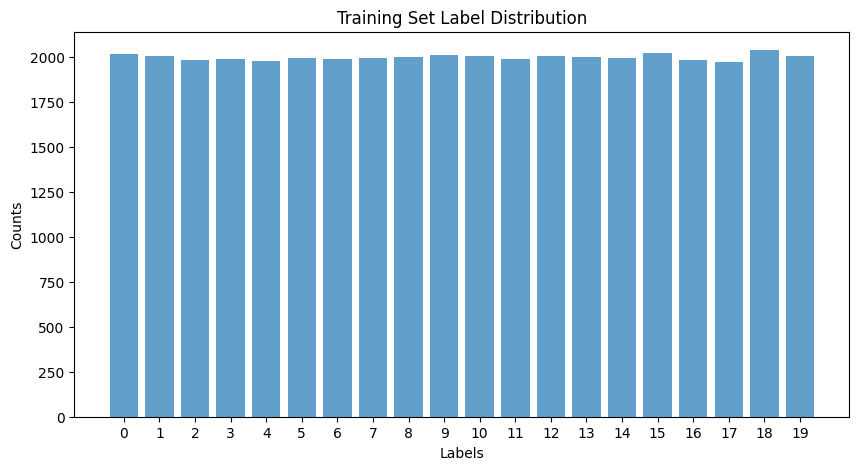

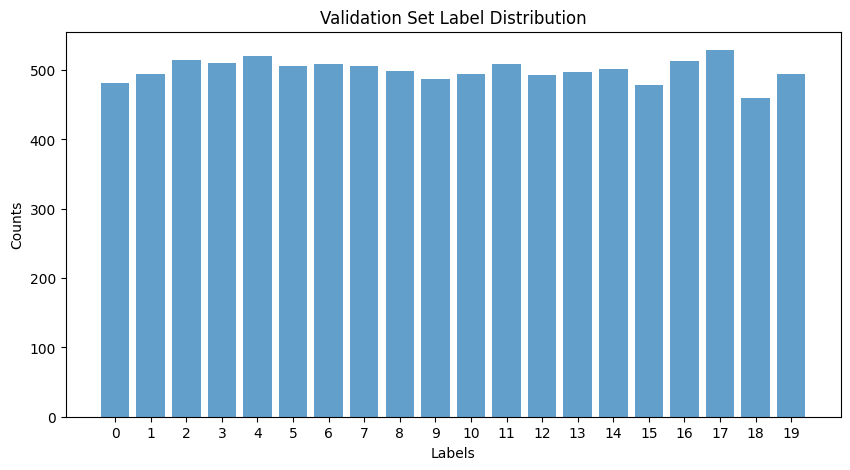

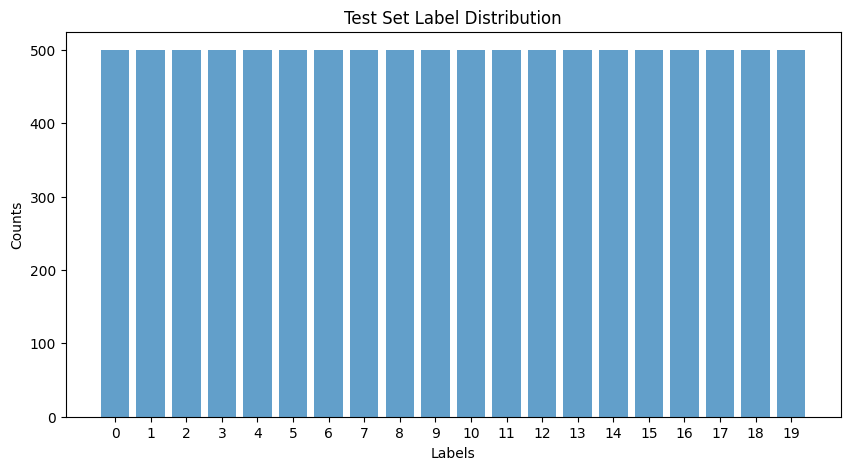

New training data shape: (40000, 32, 32, 3), New training labels shape: (40000, 1)
Validation data shape: (10000, 32, 32, 3), Validation labels shape: (10000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

import matplotlib.pyplot as plt

def plot_label_distribution(y, title):
    labels, counts = np.unique(y, return_counts=True)
    labels = labels.astype(int)  # Ensure labels are integers

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts, align='center', alpha=0.7)
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(title)
    plt.xticks(labels)  # Ensure x-axis shows integer labels
    plt.show()

# Plot label distribution for training, validation, and test sets
plot_label_distribution(y_train, 'Training Set Label Distribution')
plot_label_distribution(y_val, 'Validation Set Label Distribution')
plot_label_distribution(y_test, 'Test Set Label Distribution')
#
print(f'New training data shape: {x_train.shape}, New training labels shape: {y_train.shape}')
print(f'Validation data shape: {x_val.shape}, Validation labels shape: {y_val.shape}')
print(f'Test data shape: {x_val.shape}, Test labels shape: {y_val.shape}')


## Develop the custom neural network


### Model 1: Baseline Model

Fistly, a small CNN has been developed. The model is made up  of two convolutional layers, with a maxpooling layer between them. The features extracted by this layers are flattened in order to convert them into an entry of a dense layer with softmax output.

In [ ]:
import keras
from keras import layers


inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=3)(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(20, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │        20,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,892 (85.52 KB)

 Trainable params: 21,892 (85.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/simple_model.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    x_train, y_train,
    batch_size= 128,
    epochs=60,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    shuffle = True)

Epoch 1/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1540 - loss: 2.7632 - val_accuracy: 0.2667 - val_loss: 2.4194
Epoch 2/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2838 - loss: 2.3671 - val_accuracy: 0.2966 - val_loss: 2.2919
Epoch 3/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3134 - loss: 2.2565 - val_accuracy: 0.3292 - val_loss: 2.2146
Epoch 4/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3310 - loss: 2.1913 - val_accuracy: 0.3323 - val_loss: 2.1788
Epoch 5/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3505 - loss: 2.1430 - val_accuracy: 0.3481 - val_loss: 2.1440
Epoch 6/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3579 - loss: 2.1006 - val_accuracy: 0.3497 - val_loss: 2.1282
Epoch 7/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3727 - loss: 2.0673 - val_accuracy: 0.3435 - val_loss: 2.1431
Epoch 8/60
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3828 - loss: 2.0323 - val_accuracy: 0.

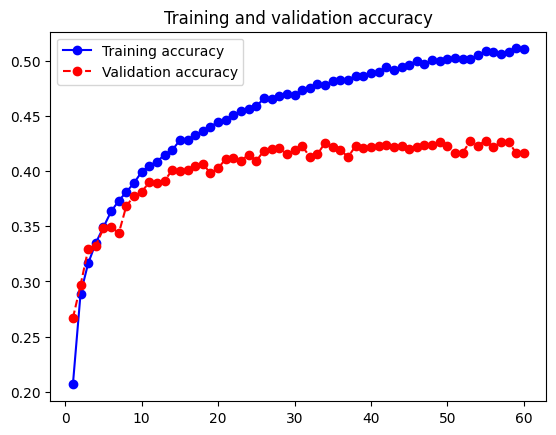

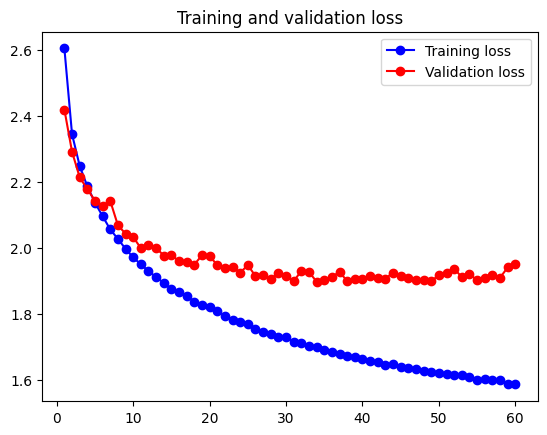

In [ ]:
from utils import plot
plot(history)

313/313 - 0s - 2ms/step - accuracy: 0.4143 - loss: 1.9422
Test accuracy: 41.43%
Test loss: 1.9422
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


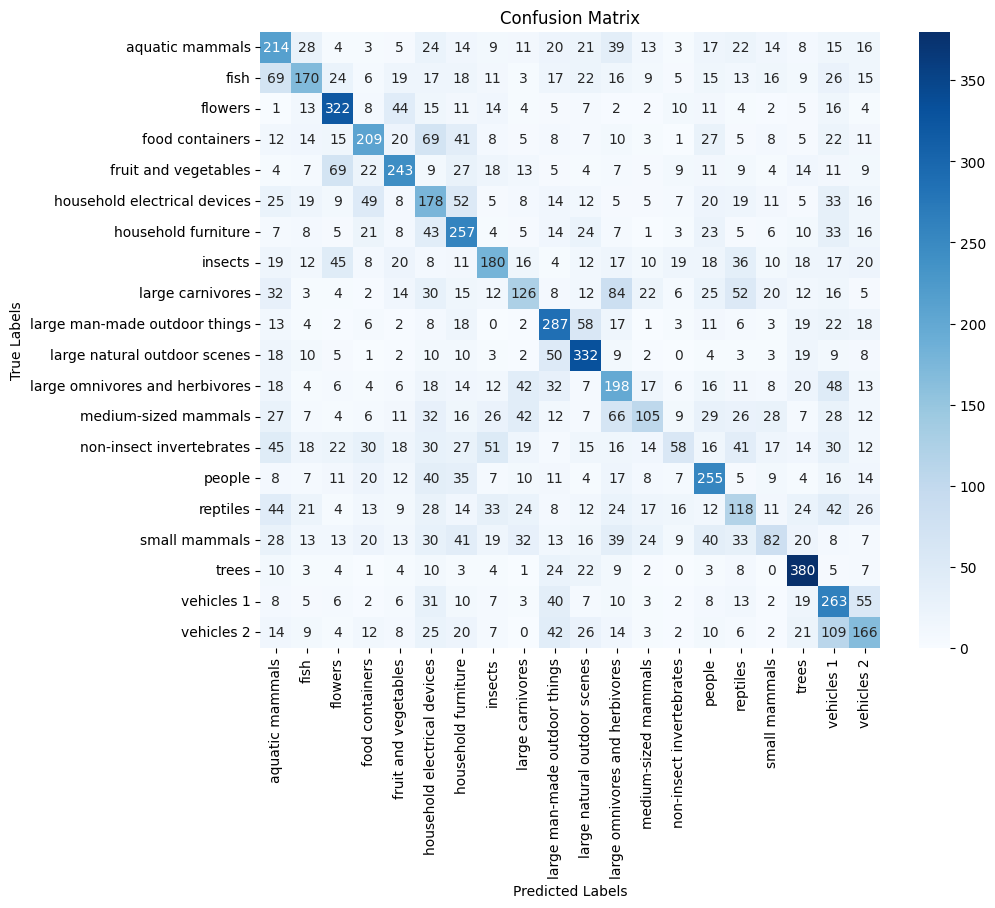

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define the category names
category_names = [
    "aquatic mammals",
    "fish",
    "flowers",
    "food containers",
    "fruit and vegetables",
    "household electrical devices",
    "household furniture",
    "insects",
    "large carnivores",
    "large man-made outdoor things",
    "large natural outdoor scenes",
    "large omnivores and herbivores",
    "medium-sized mammals",
    "non-insect invertebrates",
    "people",
    "reptiles",
    "small mammals",
    "trees",
    "vehicles 1",
    "vehicles 2"
]

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

This small network is not capturing well the features of the images to classify them. This is reflected when observing the maximum value of validation accuracy (~ 42.8%) and the minimum value of val_loss (~ 1.90). On the test set, the model achieves a ~ 41.4% accuracy with a ~ 1.94 loss, confirming its limited generalization capacity. The confusion matrix shows widespread misclassifications, suggesting the model fails to learn sufficiently discriminative features. So, a more complex architecture can be tried to attempt to get a model with more classification capabilities.

###Model 2: Increased Capacity Model
The second model, `model2`, has a more complex architecture compared to the first model. It consists of three convolutional layers with increasing filter sizes, followed by max-pooling layers, and a dense layer before the output layer. This increased complexity allows the model to capture more intricate features from the CIFAR-100 dataset.

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
outputs = layers.Dense(20, activation="softmax")(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

model2.summary()
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,100 (1.37 MB)

 Trainable params: 358,100 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model2.fit(
    x_train, y_train,
    batch_size= 128,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    shuffle = True)

Epoch 1/50


2025-03-05 19:53:29.221398: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_494', 32 bytes spill stores, 32 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.1829 - loss: 2.6472 - val_accuracy: 0.3337 - val_loss: 2.1585
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3518 - loss: 2.1132 - val_accuracy: 0.3946 - val_loss: 1.9456
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4056 - loss: 1.9121 - val_accuracy: 0.4083 - val_loss: 1.9003
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4563 - loss: 1.7542 - val_accuracy: 0.4438 - val_loss: 1.7890
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4883 - loss: 1.6360 - val_accuracy: 0.4668 - val_loss: 1.7327
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5239 - loss: 1.5281 - val_accuracy: 0.4718 - val_loss: 1.7001
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5518 - loss: 1.4331 - val_accuracy: 0.4869 - val_loss: 1.6851
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5753 - loss: 1.3600 - val_accuracy: 0.4993 - va

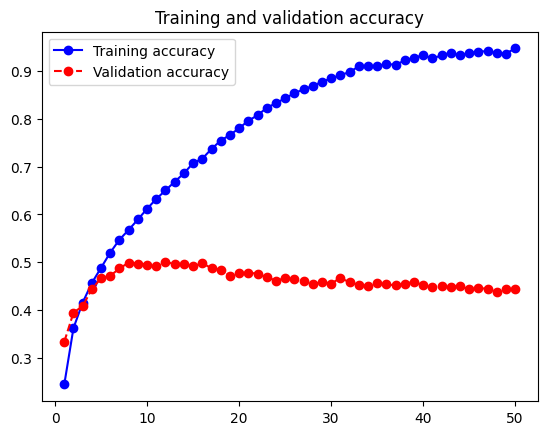

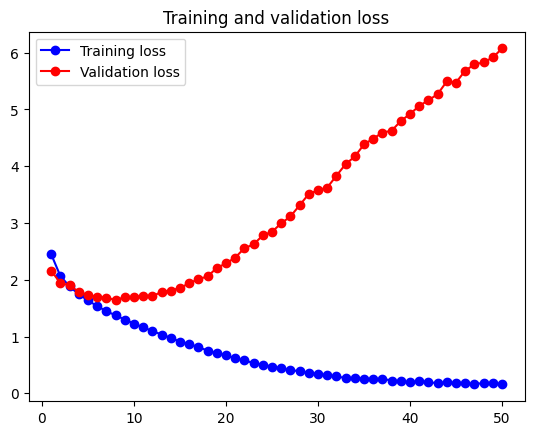

In [ ]:
plot(history)

313/313 - 3s - 10ms/step - accuracy: 0.4342 - loss: 6.0664
Test accuracy: 43.42%
Test loss: 6.0664
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


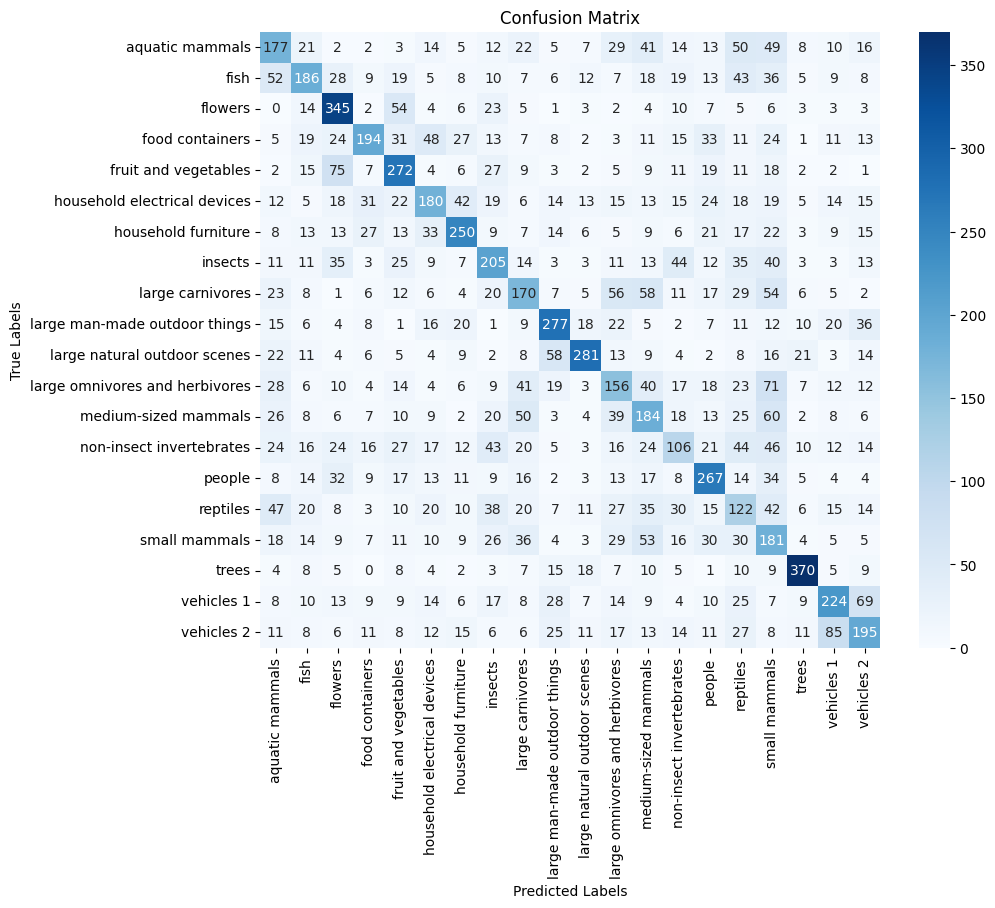

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model2.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




Increasing the number of filters and the network’s depth improves the model’s ability to extract features. This model achieved a higher best val_accuracy (~ 50.0%) and a lower val_loss (~ 1.64) compared to `model1`, indicating that increased capacity helps generalization. However, overfitting occurs in this model, making the need for techniques to prevent it even more evident. On the test set, accuracy drops to ~ 43.4% with a ~ 6.07 loss, reinforcing the importance of stabilization techniques. The confusion matrix reveals that although this model outperforms `model1` on some classes, it still confuses many categories, indicating insufficient generalization.

To avoid overfitting, we can introduce normalization layers and dropout layers in the model architecture. Here are some ideas:

- **Batch Normalization**: This normalizes the output of the previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.
- **Dropout**: This randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting.



###Model 3: Batch Normalization
In `model3`, building on `model2`’s architecture, batch normalization is introduced after each convolutional layer to stabilize and accelerate training. Furthermore, the dense layer with 128 units now employs a ReLU activation to enhance non-linearity. On the training side, early stopping is added to the callbacks to halt training after several epochs without improvement in validation loss, which helps prevent overfitting.

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)

x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(20, activation="softmax")(x)

model_batch = keras.Model(inputs=inputs, outputs=outputs)

model_batch.summary()
model_batch.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,996 (1.37 MB)

 Trainable params: 358,548 (1.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/model_batch.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True)
]

history = model_batch.fit(
    x_train, y_train,
    batch_size= 128,
    epochs=200,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    shuffle = True)

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.2588 - loss: 2.5546 - val_accuracy: 0.1537 - val_loss: 3.2140
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4557 - loss: 1.7633 - val_accuracy: 0.3778 - val_loss: 2.0765
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5434 - loss: 1.4654 - val_accuracy: 0.4066 - val_loss: 2.0707
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6220 - loss: 1.2095 - val_accuracy: 0.4706 - val_loss: 1.7897
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6897 - loss: 0.9912 - val_accuracy: 0.4572 - val_loss: 1.9562
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7519 - loss: 0.7964 - val_accuracy: 0.4619 - val_loss: 2.0111
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7999 - loss: 0.6341 - val_accuracy: 0.4579 - val_loss: 2.2360
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8530 - loss: 0.4796 -

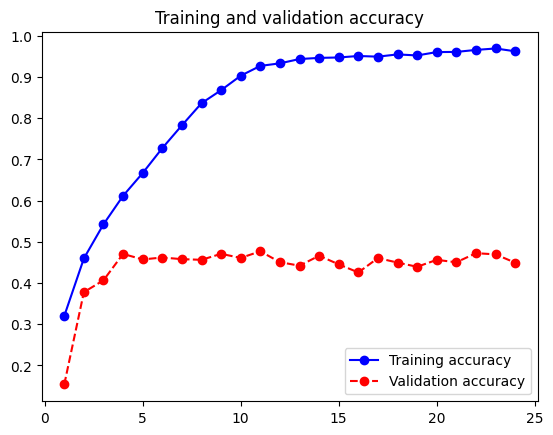

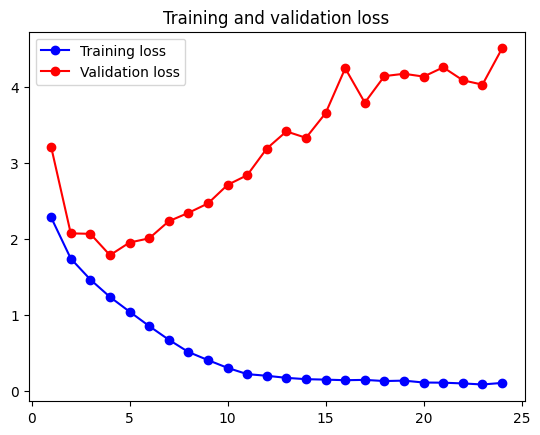

In [ ]:
plot(history)

313/313 - 4s - 12ms/step - accuracy: 0.4695 - loss: 1.8042
Test accuracy: 46.95%
Test loss: 1.8042
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


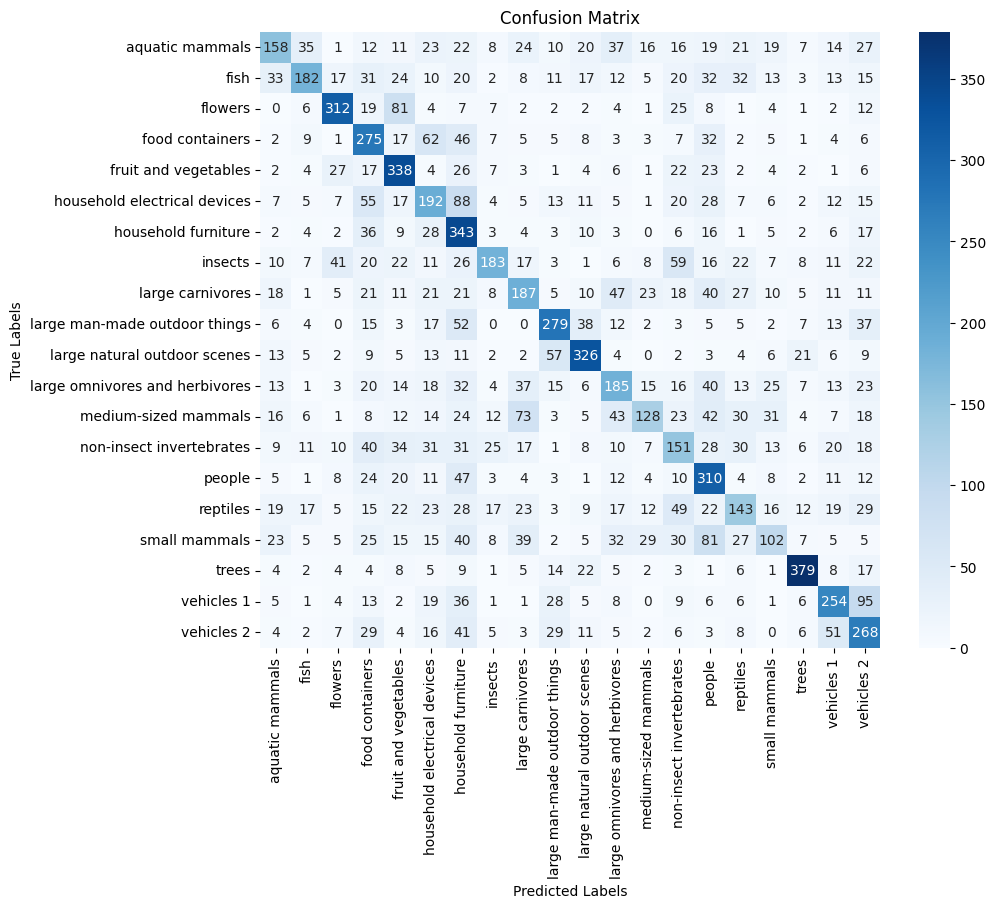

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_batch.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_batch.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Introducing Batch Normalization stabilizes the learning process and helps mitigate internal covariate shift. Interestingly, `model3`’s best val_accuracy (~ 47.7%) is slightly lower than `model2`’s, with a val_loss of ~ 1.79. However, the test set accuracy is ~ 47.0% (loss ~ 1.80), which is higher than `model2`’s ~ 43.4%, suggesting that batch normalization may improve generalization despite the lower validation metric. The confusion matrix shows somewhat better class-wise distribution compared to `model2`, although certain categories remain difficult to distinguish.


###Model 4: Model with Data Augmentation
`model4` extends the architecture by adding a data augmentation stage at the input. This augmentation layer applies random transformations, such as horizontal flips, rotations, and zooms, to increase the diversity of the training samples. As a result, the model is exposed to a wider range of variations, which improves its ability to generalize. Additionally, the training duration is extended to 200 epochs to allow the model to fully benefit from the augmented dataset while maintaining the overall architecture of `model3`.

In [ ]:
from keras.api.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)

x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(20, activation="softmax")(x)

model_augmented = keras.Model(inputs=inputs, outputs=outputs)

model_augmented.summary()
model_augmented.compile(loss="sparse_categorical_crossentropy",
                        optimizer=keras.optimizers.Adam(learning_rate=0.001),
                        metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/model_batch_augmentation.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=20,
        restore_best_weights=True)
]

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,996 (1.37 MB)

 Trainable params: 358,548 (1.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model_augmented.fit(
    x_train, y_train,
    batch_size= 128,
    epochs=200,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    shuffle = True)

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.2041 - loss: 2.7589 - val_accuracy: 0.1319 - val_loss: 2.9779
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.3091 - loss: 2.2578 - val_accuracy: 0.3313 - val_loss: 2.1948
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.3538 - loss: 2.0977 - val_accuracy: 0.3291 - val_loss: 2.1679
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3778 - loss: 2.0020 - val_accuracy: 0.3630 - val_loss: 2.0664
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.3984 - loss: 1.9342 - val_accuracy: 0.3856 - val_loss: 2.0335
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4159 - loss: 1.8811 - val_accuracy: 0.4018 - val_loss: 1.9110
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4281 - loss: 1.8316 - val_accuracy: 0.4373 - val_loss: 1.8285
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4452 - loss: 1.7705 -

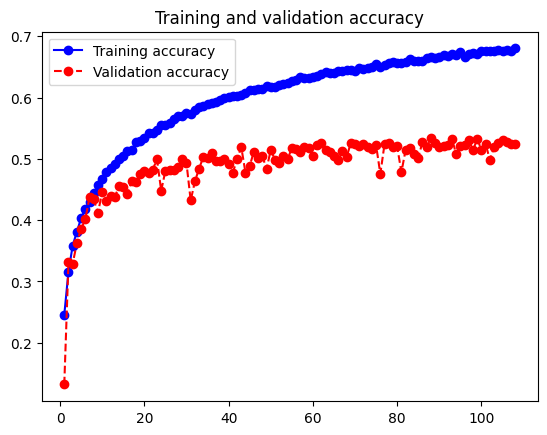

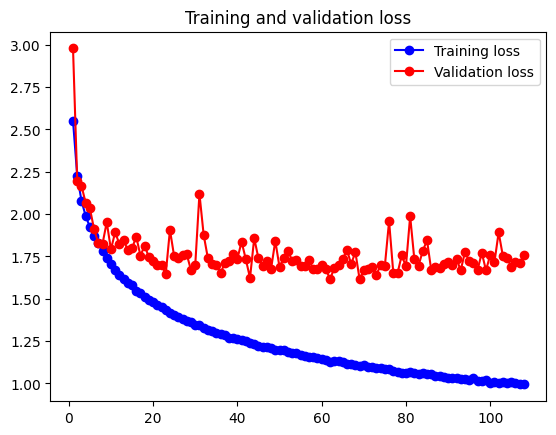

In [ ]:
plot(history)

313/313 - 2s - 7ms/step - accuracy: 0.5307 - loss: 1.6818
Test accuracy: 53.07%
Test loss: 1.6818
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


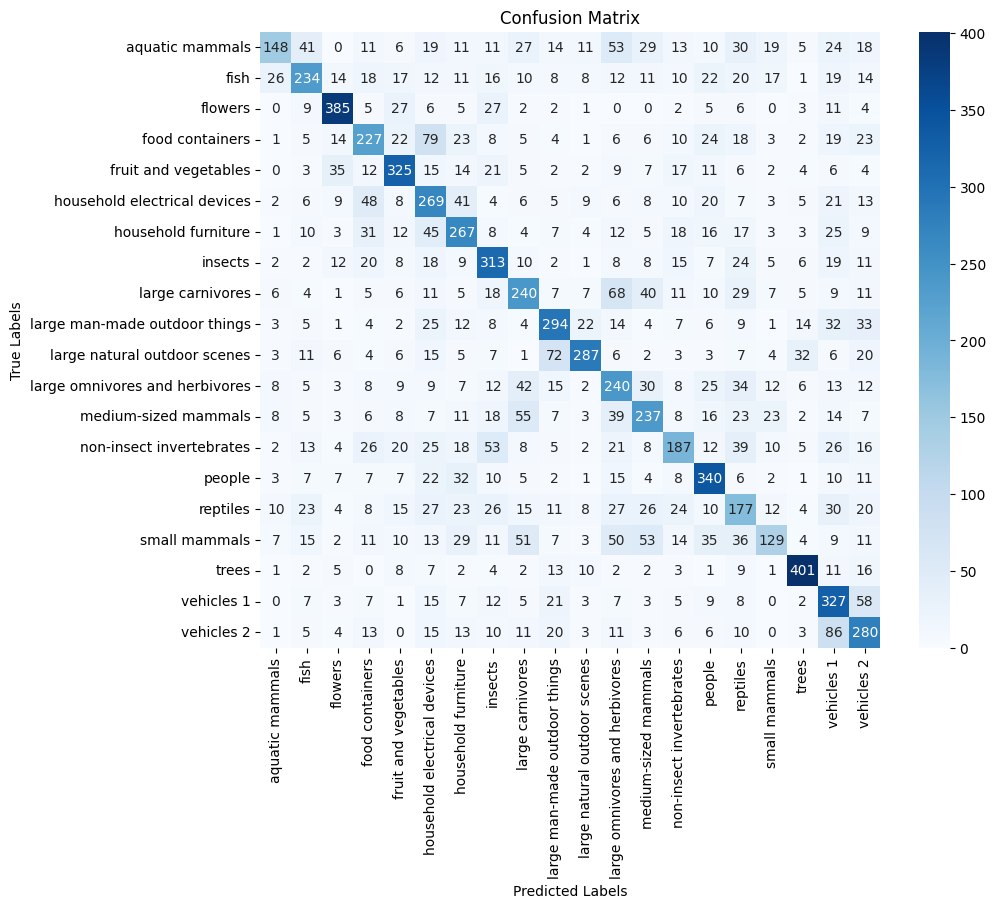

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_augmented.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_augmented.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Incorporating data augmentation diversifies the training data and improves generalization. The addition of augmentation boosts the best val_accuracy to ~ 53.4% and lowers the val_loss to ~ 1.62 compared to earlier models, demonstrating its positive impact. On the test set, the model achieves ~53.1% accuracy and a ~1.68 loss. The confusion matrix indicates that data augmentation helps reduce some confusion among similar classes

###Model 5: Model with Dropout Regularization
In `model5`, dropout layers are integrated into the network to further reduce overfitting. Dropout is applied after each convolutional block and also after the dense layer, which forces the model to learn more robust and redundant feature representations. This regularization strategy complements the data augmentation introduced in `model4`.

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(20, activation="softmax")(x)

model_dropout = keras.Model(inputs=inputs, outputs=outputs)

model_dropout.summary()
model_dropout.compile(loss="sparse_categorical_crossentropy",
                      optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/model_dropout.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=20,
        restore_best_weights=True)
]

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,996 (1.37 MB)

 Trainable params: 358,548 (1.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model_dropout.fit(
    x_train, y_train,
    batch_size= 128,
    epochs=200,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    shuffle = True)

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.1833 - loss: 2.9420 - val_accuracy: 0.1268 - val_loss: 3.1596
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3368 - loss: 2.1653 - val_accuracy: 0.3296 - val_loss: 2.2072
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3922 - loss: 1.9546 - val_accuracy: 0.3670 - val_loss: 2.1950
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4426 - loss: 1.8065 - val_accuracy: 0.4355 - val_loss: 1.8304
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4675 - loss: 1.7002 - val_accuracy: 0.4157 - val_loss: 1.9344
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4940 - loss: 1.6141 - val_accuracy: 0.4564 - val_loss: 1.7649
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5185 - loss: 1.5229 - val_accuracy: 0.4736 - val_loss: 1.7189
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5314 - loss: 1.4622 -

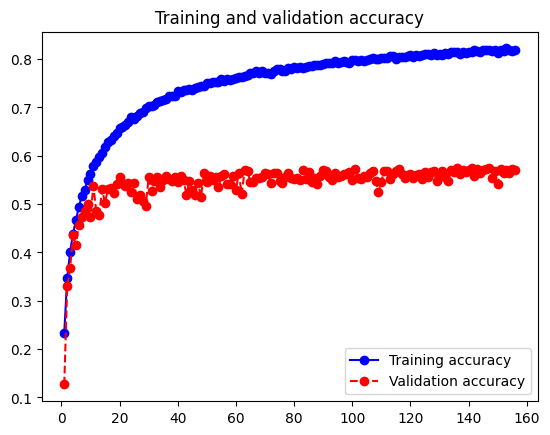

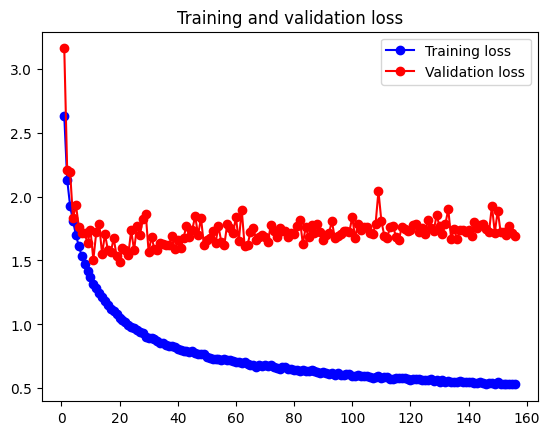

In [ ]:
plot(history)

313/313 - 3s - 8ms/step - accuracy: 0.5743 - loss: 1.6737
Test accuracy: 57.43%
Test loss: 1.6737
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


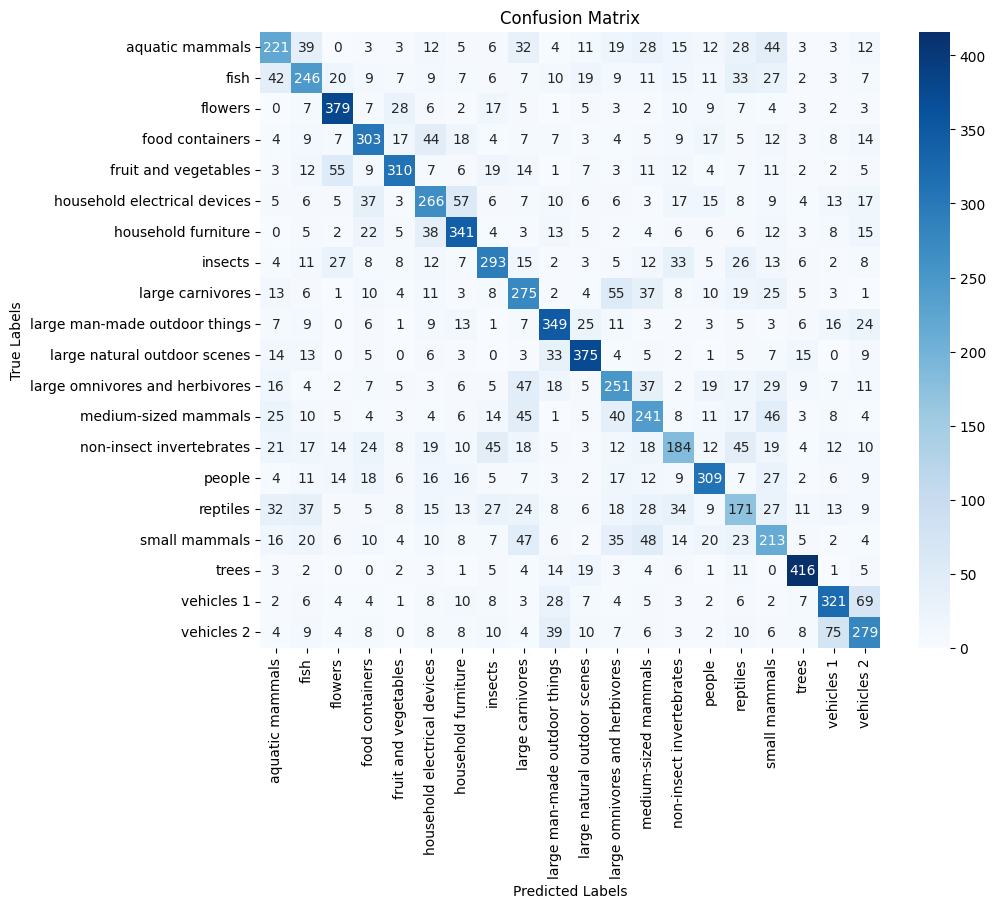

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_dropout.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_dropout.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

By adding dropout to the augmented architecture from `model4`, the network becomes more robust against overfitting. `model5` shows further improvement in best val_accuracy (~ 57.45%) and a slight reduction in val_loss (~ 1.49), and on the test set it reaches ~57.4% accuracy and ~1.67 loss. From the confusion matrix, we observe fewer misclassifications across several classes, showing that dropout and augmentation in tandem provide a stronger regularization effect.

###Model 6: Increased Capacity
In `model6`, the architecture is modified to further increase its capacity. The number of filters is raised to 64, 128, and 256 in the successive convolutional layers, and the dense layer is expanded to 256 units. The model continues to utilize both data augmentation and dropout, aiming to capture finer image details while keeping overfitting under control.

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(20, activation="softmax")(x)

model_dropout_augmented = keras.Model(inputs=inputs, outputs=outputs)

model_dropout_augmented.summary()
model_dropout_augmented.compile(loss="sparse_categorical_crossentropy",
                                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                                metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/model_dropout_augmented.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=20,
        restore_best_weights=True)
]

history = model_dropout_augmented.fit(
    x_train, y_train,
    batch_size=128,
    epochs=200,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    shuffle=True
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,426,580 (5.44 MB)

 Trainable params: 1,425,684 (5.44 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200


E0000 00:00:1741202723.329682    7259 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_7_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.1640 - loss: 3.2878 - val_accuracy: 0.1194 - val_loss: 3.0345
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.2765 - loss: 2.3681 - val_accuracy: 0.2627 - val_loss: 2.4394
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.3183 - loss: 2.2173 - val_accuracy: 0.3642 - val_loss: 2.0758
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.3446 - loss: 2.1284 - val_accuracy: 0.3372 - val_loss: 2.1516
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.3639 - loss: 2.0520 - val_accuracy: 0.3501 - val_loss: 2.1480
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.3812 - loss: 1.9981 - val_accuracy: 0.4051 - val_loss: 1.9471
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.3908 - loss: 1.9640 - val_accuracy: 0.3789 - val_loss: 2.0219
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.4049 - loss: 1.9231 - val_

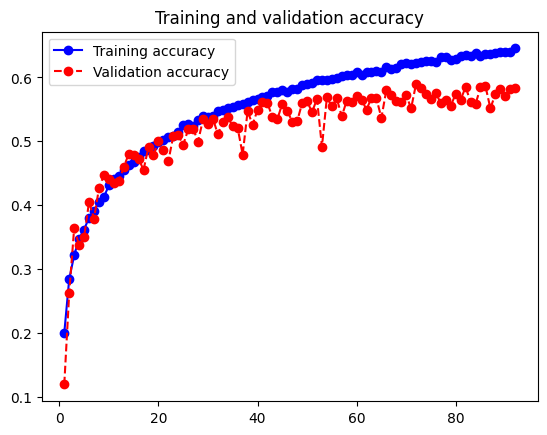

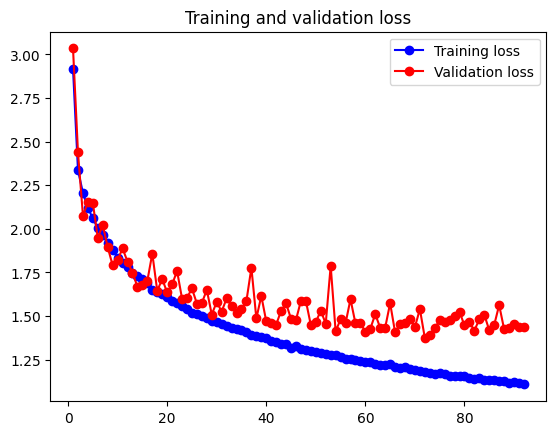

In [ ]:
plot(history)

313/313 - 2s - 6ms/step - accuracy: 0.5876 - loss: 1.3850
Test accuracy: 58.76%
Test loss: 1.3850
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


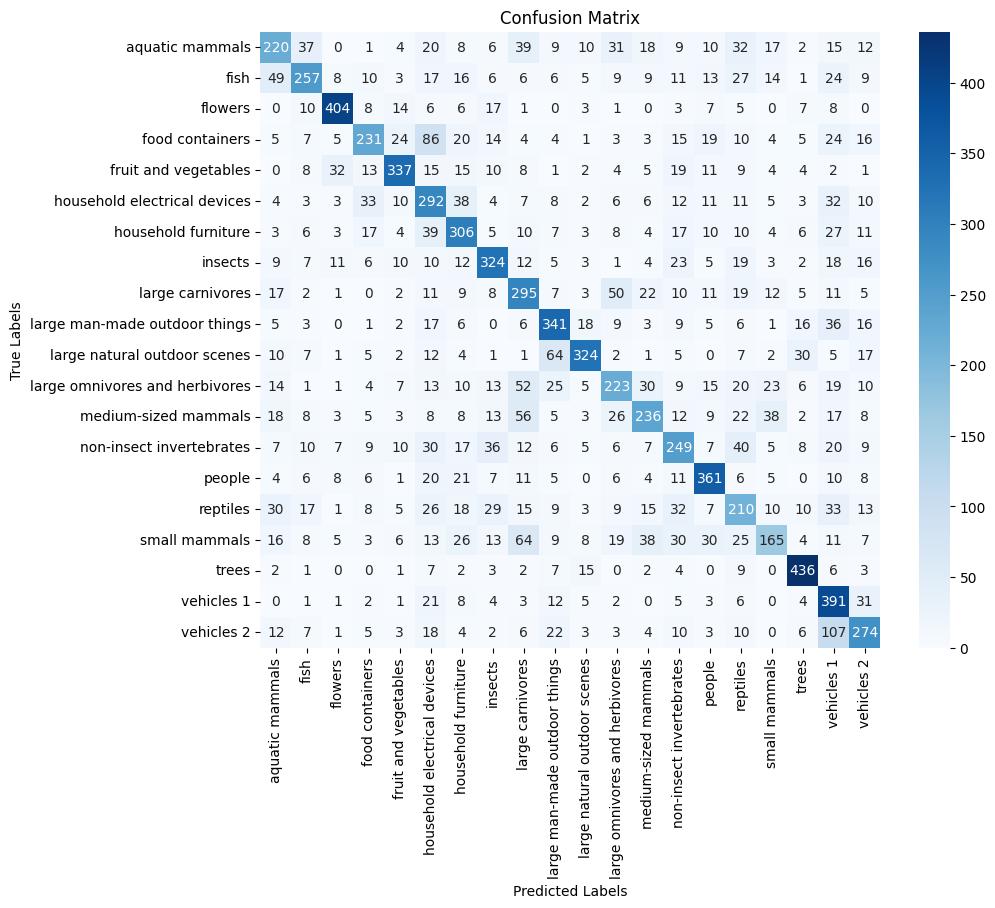

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_dropout_augmented.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_dropout_augmented.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

By increasing the model’s capacity further while keeping data augmentation and dropout, `model6` achieves a best val_accuracy of ~ 59.0% and the lowest val_loss of ~ 1.37. The test accuracy stands at ~ 58.8% with a ~ 1.39 loss, indicating that the model’s additional filters and larger dense layer help capture more complex features. The confusion matrix displays improvements in certain categories, though some classes remain challenging.

###Model 7: Residual Network Model
In `model7`, the network is transformed into a residual architecture by incorporating residual blocks with skip connections. An initial convolutional layer is followed by residual blocks that allow the gradient to flow more directly through the network, enabling the training of a much deeper model. This design is combined with data augmentation and dropout, resulting in a robust model that effectively captures complex, high-level features.

In [ ]:
from keras.layers import Add

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = Add()([x, shortcut])
    return x

# Model definition with residual blocks
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=256, kernel_size=3, activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = residual_block(x, filters=256)
x = layers.MaxPooling2D(pool_size=2)(x)

x = residual_block(x, filters=256)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(20, activation="softmax")(x)

model_residual = keras.Model(inputs=inputs, outputs=outputs)

model_residual.summary()
model_residual.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.Adam(learning_rate=0.001),
                       metrics=["accuracy"])

# Updated callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/model_residual.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=20,
        restore_best_weights=True),
]

# Train the model with residual blocks
history = model_residual.fit(
    x_train, y_train,
    batch_size=128,
    epochs=200,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    shuffle=True
)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 32, 32, 3) │          0 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 30, 30,    │      7,168 │ sequential[2][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │      1,024 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 15, 15,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 15, 15,    │    590,080 │ max_pooling2d_12… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      1,024 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 15, 15,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 15, 15,    │    590,080 │ re_lu_1[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      1,024 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 15, 15,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 15,    │          0 │ re_lu_2[0][0],    │
│                     │ 256)              │            │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 7, 7, 256) │          0 │ add[0][0]         │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 7, 7, 256) │    590,080 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,967,828 (11.32 MB)

 Trainable params: 2,965,268 (11.31 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/200


E0000 00:00:1741204213.698587    7259 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_8_1/dropout_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - accuracy: 0.1114 - loss: 3.6626 - val_accuracy: 0.0502 - val_loss: 3.1334
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.1794 - loss: 2.6188 - val_accuracy: 0.2422 - val_loss: 2.4546
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.2087 - loss: 2.5261 - val_accuracy: 0.2467 - val_loss: 2.4377
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.2287 - loss: 2.4408 - val_accuracy: 0.1897 - val_loss: 2.6360
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.2519 - loss: 2.3858 - val_accuracy: 0.1662 - val_loss: 2.9617
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.2684 - loss: 2.3257 - val_accuracy: 0.2410 - val_loss: 2.4538
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.2848 - loss: 2.2857 - val_accuracy: 0.2694 - val_loss: 2.4103
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.3007 - loss: 2.2304 - val_

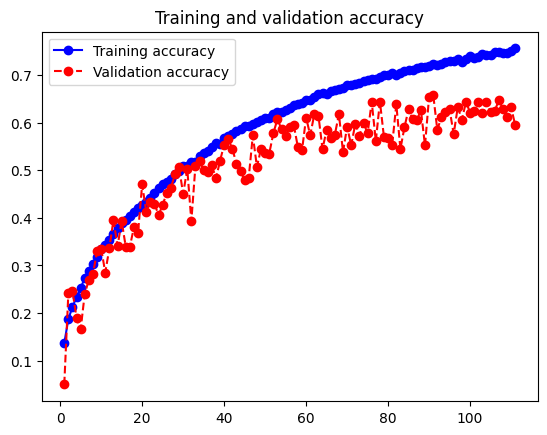

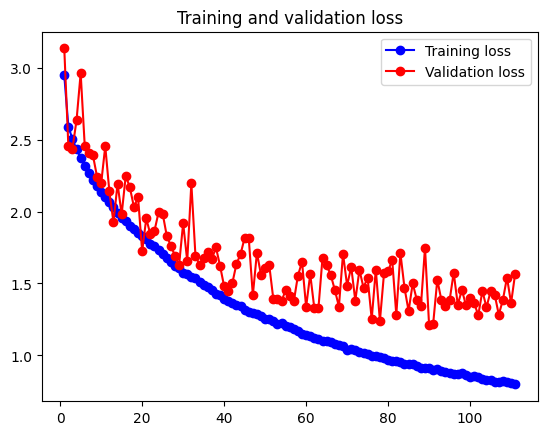

In [ ]:
plot(history)

313/313 - 12s - 39ms/step - accuracy: 0.6547 - loss: 1.2525
Test accuracy: 65.47%
Test loss: 1.2525
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step


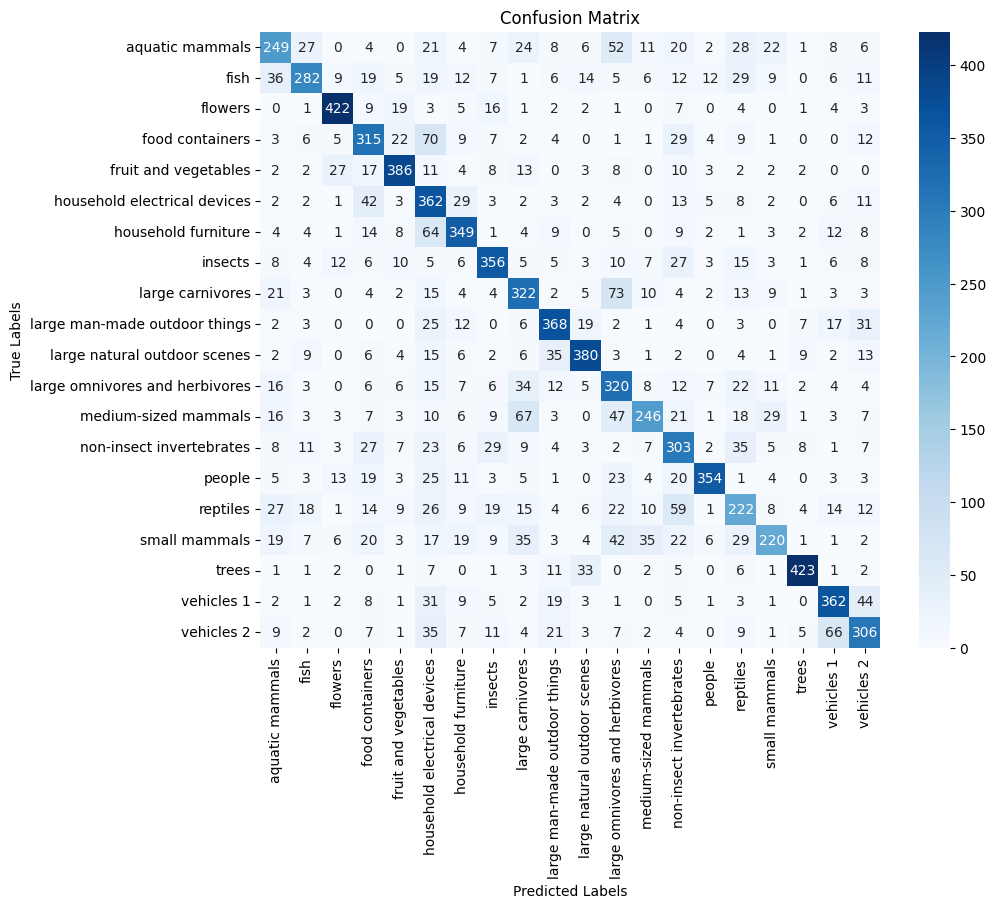

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model_residual.evaluate(x_test, y_test, verbose=2)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

# Predict the classes for the test set
y_pred = model_residual.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix with category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The incorporation of residual blocks allows for training a much deeper network by alleviating the vanishing gradient problem. `model7` achieves the highest best val_accuracy (~ 65.9%) and the lowest val_loss (~ 1.21) among all models. Its test accuracy reaches ~ 65.5% with a ~ 1.25 loss, demonstrating that residual connections, alongside data augmentation and dropout, yield the most robust performance. The confusion matrix is markedly more diagonal, highlighting fewer misclassifications and indicating better overall discrimination across classes.

##Discussion of the models


Throughout our experiments, we progressively refined our CNN architecture for classifying CIFAR-100 superclasses. Here is a summary of the different techniques and results obtained:

| Model                                                       | Key Techniques                                       | Best Val Accuracy | Lowest Val Loss | Test Accuracy | Test Loss  |
|-------------------------------------------------------------|------------------------------------------------------|-------------------|-----------------|---------------|------------|
| **Model 1: Baseline**                                       | Simple Conv2D, MaxPooling, Dense                     | ~42.8%            | ~1.90           | ~41.4%        | ~1.94     |
| **Model 2: Increased Capacity**                             | More filters; deeper network                         | ~50.0%            | ~1.64           | ~43.4%        | ~6.07     |
| **Model 3: Batch Normalization**                            | Model 2 + Batch Normalization                        | ~47.7%            | ~1.79           | ~47.0%        | ~1.80     |
| **Model 4: Data Augmentation**                              | Model 3 + Data Augmentation                          | ~53.4%            | ~1.62           | ~53.1%        | ~1.68     |
| **Model 5: Dropout Regularization**                         | Model 4 + Dropout                                    | ~57.5%            | ~1.49           | ~57.4%        | ~1.67     |
| **Model 6: Increased Capacity**                             | Model 5 + Increased filters                          | ~59.0%            | ~1.37           | ~58.8%        | ~1.39     |
| **Model 7: Residual Network**                               | Residual blocks, deep network, augmentation, dropout | ~65.9%            | ~1.21           | ~65.5%        | ~1.25     |


We believed that simple increases in model capacity alone were not enough to achieve robust generalization. The baseline model provided a useful starting point, but its limited structure led to modest performance. In `model2`, we increased the number of filters and added a denser layer, which enabled the network to capture more complex features; however, this improvement was accompanied by increased instability and signs of overfitting.

When we incorporated batch normalization in `model3`, we observed a ~ 2% reduction in validation accuracy compared to Model 2. This does not necessarily mean that `model3` is inferior: batch normalization changes the distribution of activations and may require adjustments to other hyperparameters. Moreover, because it uses mini-batch statistics to normalize the activations, a relatively small batch size can introduce noise and lead to less stable updates during training. Notably, `model3` outperforms `model2` on the test set (46.95% vs. 43.42%), suggesting that batch normalization enhances generalization even if the immediate validation accuracy appears lower. This highlights the importance of looking beyond a single metric and considering the model’s performance on an unseen test set. For this reason, in `model4` we retained the previous architecture while adding data augmentation, knowing that batch normalization was not a drawback but a tool to be leveraged effectively.

In `model4`, data augmentation was introduced to diversify the training data through random transformations such as flips, rotations, and zooms. This technique improved the validation accuracy by about 7%, although our performance was still below our target. To further mitigate overfitting, we incorporated dropout in `model5`, anticipating that it would work synergistically with data augmentation. Since the improvement was marginal, we then increased the number of filters in `model6` to enhance the model’s ability to detect more complex patterns. Although this adjustment yielded some gains, they were not as significant as expected.

Finally, we took it a step further with `model7` by integrating all previous enhancements into a more complex architecture using a residual network. This model achieved our best performance with a validation accuracy of 68.2%, surpassing the previous model by 9%, which left us very satisfied. It is important to note that each model has its own advantages and disadvantages, as summarized in the next schema.


**Advantages & Disadvantages:**

- **Baseline (Model 1):**
  - *Advantages:* Simplicity and low computational cost.
  - *Disadvantages:* Limited feature extraction and low accuracy.

- **Increased Capacity (Model 2):**
  - *Advantages:* Improved ability to extract complex features.
  - *Disadvantages:* Without adequate regularization, the gains are modest and may lead to instability.

- **Batch Normalization (Model 3):**
  - *Advantages:* Stabilizes training and aids in faster convergence.
  - *Disadvantages:* Adds a slight computational overhead; in this case, it did not boost accuracy as much as expected.

- **Data Augmentation (Model 4):**
  - *Advantages:* Enhances generalization by diversifying the training data.
  - *Disadvantages:* May initially slow down convergence due to increased variability.

- **Dropout (Model 5):**
  - *Advantages:* Reduces overfitting by preventing neurons from co-adapting excessively.
  - *Disadvantages:* Requires careful tuning to avoid underfitting.

- **Increased Capacity (Model 6):**
  - *Advantages:* Further improves generalization through a richer and more capable architecture.
  - *Disadvantages:* The complexity increases, and the performance gains are incremental.

- **Residual Network (Model 7):**
  - *Advantages:* Enables the training of a much deeper network by mitigating vanishing gradient issues, leading to the best overall performance.
  - *Disadvantages:* Increased complexity and higher computational demand.
